# Uma introdução gentil a analise de dados de fMRI em Python usando Brainiak

### Trabalho Final Disciplina Fundamentos da Ciência de Dados - FT043

##### Paulo Cardoso - 234956

### I) Setup e apresentação dos dados
#### A) Importando Bibliotecas

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
from time import time
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import scipy.io
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_validate, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFECV, f_classif
from sklearn.pipeline import Pipeline
%matplotlib inline 
%autosave 120
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 120 seconds


#### B) Importando funções auxiliares do arquivo utils.py

In [2]:
from utils import load_vdc_stim_labels, load_vdc_mask, load_vdc_epi_data, load_vdc_masked_data 
from utils import vdc_data_dir, vdc_hrf_lag, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, nb2_simulated_data, vdc_hrf_lag, vdc_TR, vdc_TRs_run
from utils import load_labels, load_data, blockwise_sampling, label2TR, shift_timing, reshape_data
from utils import normalize, decode

print('Here are some constants, which is specific to the VDC data:')
print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %s' % (vdc_n_runs))
print('1 TR = %.2f sec' % (vdc_TR))
print('HRF lag = %.2f sec' % (vdc_hrf_lag))
print('num TRs per run = %d' % (vdc_TRs_run))

Here are some constants, which is specific to the VDC data:
data dir = /home/osboxes/brainiak_datasets/vdc
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.50 sec
HRF lag = 4.50 sec
num TRs per run = 310


#### C) Formato e estrutura dos dados 

In [3]:
sub = 'sub-01'
stim_label_allruns = load_vdc_stim_labels(sub)
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))

stim_label_allruns has shape:  (10, 450)


In [4]:
header_file=os.path.join(vdc_data_dir,'README.txt')
!head -50 $header_file

1. Data structure

my_dataset/
├── README.txt 							# This file, Contains experimental design/task details, imaging parameters, and description of the directory structure
├── DESIGN.txt 							# Descriptions of design matrixes (in design_matrix folder)
├── sub-01/								
	├── day1								# Data of the first fMRI session (day 1)
	│   ├── anat
	│   │   ├── sub-01_fieldmap_01.nii.gz		# Field map image to correct B0 inhomogeneities 
	│   │   ├── sub-01_fieldmap_02.nii.gz
	│   │   ├── sub-01_t1_flash01.nii.gz		# Fast Low Angle shot anatomical scan
	│   │   ├── sub-01_t1_mprage.nii.gz		# raw 3-D structural image (T1-weighted magnetization prepared rapid acquisition gradient-echo image)
	│   │   ├── sub-01_t2_tse_01.nii.gz		# T2-weighted turbo spin echo image for hippocampal segmentation
	│   │   └── sub-01_t2_tse_02.nii.gz		
	│   └── func
	│       ├── sub-01_study_01.nii.gz			# Raw 4-D functional image of a study phase (run 1-6)
	│       ├── sub-01_study_02.nii.gz
	│       ├── sub-01_study

#### D) Plot da apresentação de estimulo na run 1

In [5]:
run_id = 1

# linha 6 representa o run_id, filtrando dataset por run_id 1
time_points_mask = stim_label_allruns[5,:] == run_id

# linha 1 representa a label conforme apresentado no bloco B)
labels = stim_label_allruns[0, time_points_mask]

# linha 3 representa o time_secs (tempo em segundos)
time_secs = stim_label_allruns[2, time_points_mask]

print('labels:\n\n %s \n\n' % labels)
print('time_secs:\n\n%s' % time_secs)

labels:

 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.] 


time_secs:

[ 12.   13.5  15.   16.5  18.   19.5  21.   22.5  24.   25.5  42.   43.5
  45.   46.5  48.   49.5  51.   52.5  54.   55.5  72.   73.5  75.   76.5
  78.   79.5  81.   82.5  84.   85.5 102.  103.5 105.  106.5 108.  109.5
 111.  112.5 114.  115.5 132.  133.5 135.  136.5 138.  139.5 141.  142.5
 144.  145.5 162.  163.5 165.  166.5 168.  169.5 171.  172.5 174.  175.5
 192.  193.5 195.  196.5 198.  199.5 201.  202.5 204.  205.5 222.  223.5
 225.  226.5 228.  229.5 231.  232.5 234.  235.5 252.  253.5 255.  256.5
 258. 

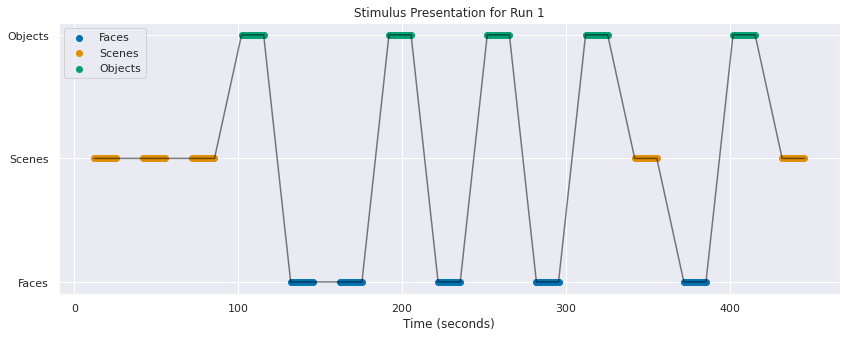

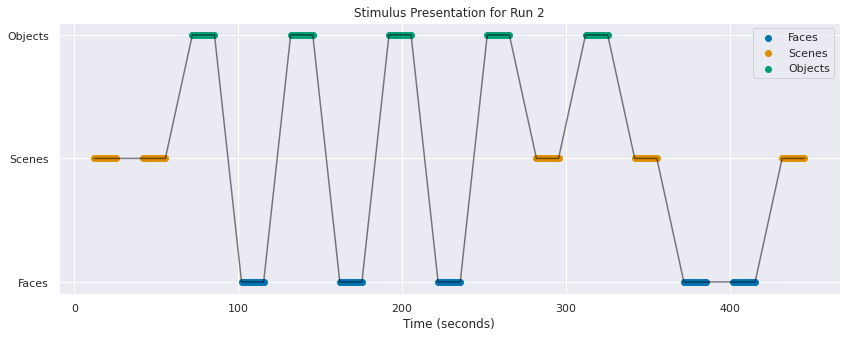

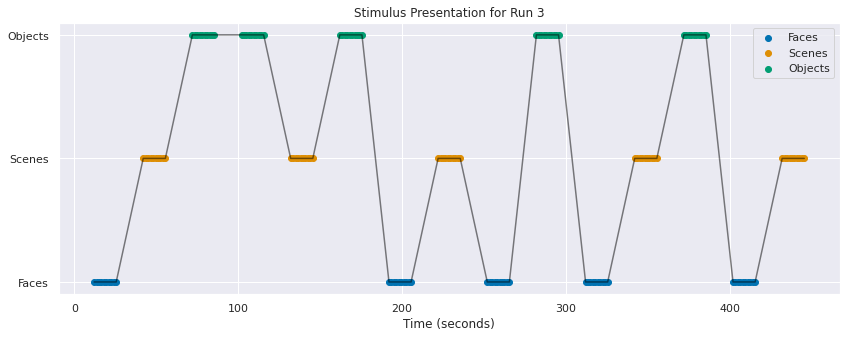

In [6]:
for x in range(1,4):
        time_points_mask = stim_label_allruns[5,:] == x
        labels = stim_label_allruns[0, time_points_mask]
        time_secs = stim_label_allruns[2, time_points_mask]
        
        
        n_conditions = len(vdc_label_dict)
        cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

        # create a plotting panel 
        f, ax = plt.subplots(1,1, figsize = (14, 5))

        # plot the label for each condition
        for i_cond in range(n_conditions): 
            label = list(vdc_label_dict.keys())[i_cond]
            temp_mask = label == labels
            ax.scatter(time_secs[temp_mask], labels[temp_mask], 
                       color = cur_pals[i_cond], marker = 'o')
        ax.legend(vdc_label_dict.values())

        # connect the dots 
        ax.plot(time_secs, labels, color = 'black', alpha = .5)

        # mark the plot
        ax.set_title('Stimulus Presentation for Run %d' % (x))
        ax.set_yticks(list(vdc_label_dict.keys()))
        ax.set_yticklabels(vdc_label_dict.values())
        ax.set_xlabel('Time (seconds)');

#### E) Carregando dados fMRI (FFA e PPA)

In [7]:
print('Regiões de interesse (ROI):', vdc_all_ROIs)

Regiões de interesse (ROI): ['FFA', 'PPA']


In [8]:
ROI_name = 'FFA'

# 1. Load the fMRI data 
epi_data = load_vdc_epi_data(sub, run_id)

# 2. Load the mask file 
mask = load_vdc_mask(ROI_name, sub)

# 3. Apply ROI mask
nifti_masker = NiftiMasker(mask_img=mask)
maskedData = nifti_masker.fit_transform(epi_data)

print('Data shape - before masking: ', epi_data.shape)
print('Data shape - after masking: ', maskedData.shape)
print('Mask name: ', ROI_name)

Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loaded FFA mask
Data shape - before masking:  (128, 128, 52, 310)
Data shape - after masking:  (310, 5519)
Mask name:  FFA


#### F) Plot  da serie temporal de um voxel

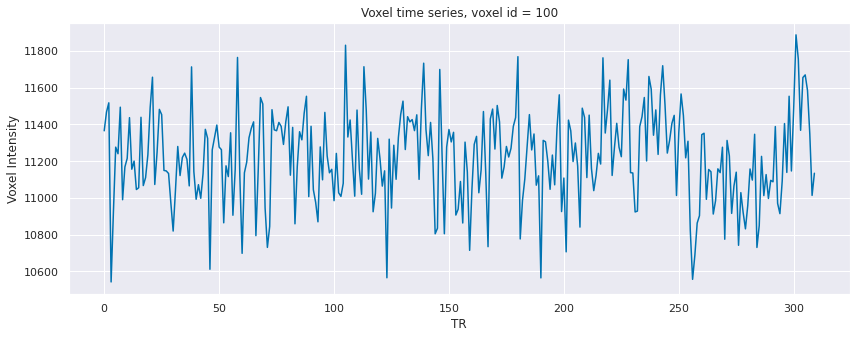

In [9]:
# Plot a voxel value (in this example of voxel 100) through time
voxel_id = 100

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(maskedData[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity');

#### G) Normalização dos dados e avaliando zscore

In [10]:
maskedData_zscore = preprocessing.StandardScaler().fit_transform(maskedData)

In [11]:
voxel_mean = np.mean(maskedData_zscore, axis=0)
voxel_std = np.std(maskedData_zscore, axis=0)
print('The number of voxels in the mask is %d' % len(voxel_mean));
print('The mean of the first few voxels:\n', voxel_mean[0:4])
print('The std of the first few voxels:\n', voxel_std[0:4])

The number of voxels in the mask is 5519
The mean of the first few voxels:
 [ 2.6533680e-08 -1.9179236e-08 -6.3450107e-09 -4.2300070e-09]
The std of the first few voxels:
 [1.0000002 1.        1.        1.0000001]


Text(0, 0.5, 'Count')

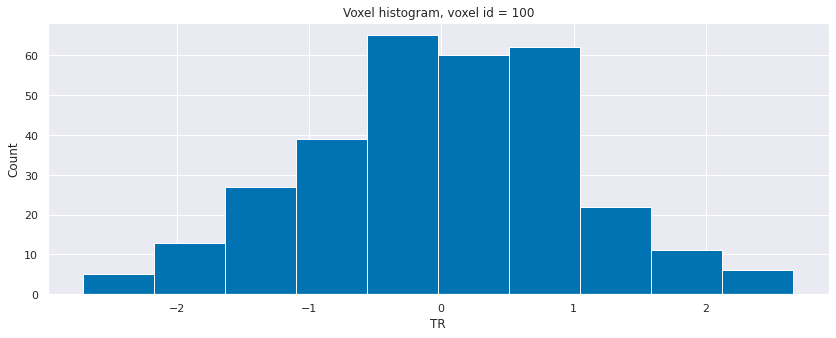

In [12]:
voxel_id = 100
f, ax = plt.subplots(1,1, figsize=(14,5))
ax.hist(maskedData_zscore[:, voxel_id])
ax.set_title('Voxel histogram, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Count')

#### H) Normalização por meio do zscore

In [13]:
maskedData_normalized = np.divide((maskedData - np.mean(maskedData, axis=0)),
                                  np.std(maskedData, axis=0))
print(maskedData_normalized)

[[ 2.8456168   3.2628112   2.5052717  ...  0.07863739  0.38969308
   0.3045837 ]
 [ 1.2489911   1.3947434   0.77103186 ... -0.43905276  0.6227999
   1.0112889 ]
 [-1.5144085  -0.8115648  -0.25172088 ...  0.44194567 -2.5218987
  -0.08139013]
 ...
 [-0.81020397  0.35530525  0.31352705 ...  0.5586276  -0.6733996
   0.9124255 ]
 [ 0.10225026 -0.562929    0.30930847 ... -1.3336943  -0.3834965
  -1.1480132 ]
 [-0.41949862  0.08342449 -0.23968233 ...  0.15900172  1.532989
   0.50872403]]


In [14]:
print(maskedData_zscore)

[[ 2.8456116   3.2628145   2.5052931  ...  0.07864174  0.38969463
   0.30458578]
 [ 1.2489864   1.394747    0.7710531  ... -0.4390484   0.6228014
   1.011291  ]
 [-1.5144131  -0.8115614  -0.25169975 ...  0.44195002 -2.521897
  -0.08138805]
 ...
 [-0.81020856  0.35530868  0.3135482  ...  0.5586319  -0.67339796
   0.9124276 ]
 [ 0.10224554 -0.5629256   0.30932966 ... -1.3336899  -0.38349488
  -1.1480111 ]
 [-0.4195033   0.08342789 -0.23966119 ...  0.15900604  1.5329905
   0.5087261 ]]


In [15]:
maskedData.shape

(310, 5519)

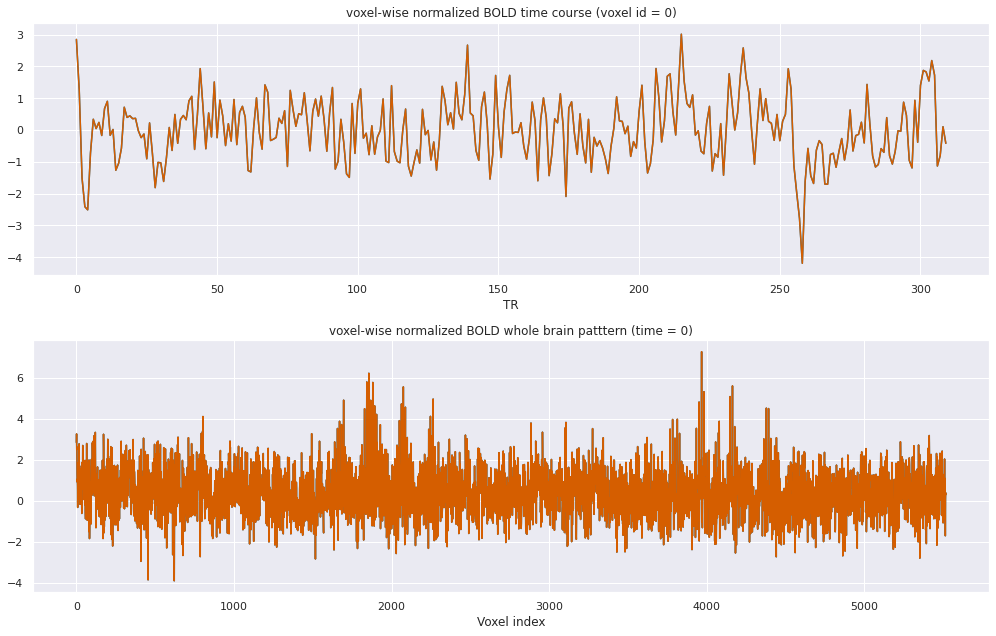

In [16]:
if maskedData_zscore is not None:
    f, axes = plt.subplots(2,1,figsize = (14,9))
    v = 0
    t = 0 

    # Plot the results for the a feature vector at one time-point
    axes[0].plot(maskedData_normalized[:, v], 'b-')
    axes[0].plot(maskedData_zscore[:, v], 'r-')
    axes[0].set_title('voxel-wise normalized BOLD time course (voxel id = %d)' % (v))
    axes[0].set_xlabel('TR')

    # Plot the time-series for one voxel
    axes[1].plot(maskedData_normalized[t, :], 'b-')
    axes[1].plot(maskedData_zscore[t, :], 'r-')
    axes[1].set_title('voxel-wise normalized BOLD whole brain patttern (time = %d)' % (t))
    axes[1].set_xlabel('Voxel index')

    f.tight_layout()
else:
    print('Please assign Z-score values in the previous step to maskedData_normalized.')

### II) Classificação

#### A) Carregamento  e normalização de dados

In [17]:
sub = 'sub-01';
# definição d função para carregar labels
def load_vdc_stim_labels(vdc_data_dir, subject_id):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1, vdc_n_runs+1):
        in_file = os.path.join(vdc_data_dir,subject_id,'ses-day2','design_matrix','%s_localizer_0%d.mat' % 
                               (subject_id, run))
        # Load in data from MATLAB
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))
    print("Loaded labels for", subject_id)
    return stim_label_concatenated

stim_label_allruns = load_vdc_stim_labels(vdc_data_dir, sub)

Loaded labels for sub-01


In [18]:
# Define the function
def label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, vdc_TRs_run):
    # Preset variables
    _, events = stim_label_allruns.shape
    events_run = int(events / vdc_n_runs)

    # Preset the array with zeros
    stim_label_TR = np.zeros((vdc_TRs_run * 3, 1))

    # Cycle through the runs
    for run in range(vdc_n_runs):

        # Cycle through each element in a run
        for i in range(events_run):

            # What element in the concatenated timing file are we accessing
            time_idx = run * (events_run) + i

            # What is the time stamp
            time = stim_label_allruns[2, time_idx]

            # What TR does this timepoint refer to?
            TR_idx = int(time / vdc_TR) + (run * (vdc_TRs_run - 1))

            # Add the condition label to this timepoint
            stim_label_TR[TR_idx] = stim_label_allruns[0, time_idx]
            
    return stim_label_TR


stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, vdc_TRs_run)

#### B) Plot das condições diferentes

Text(0.5, 0, 'Time in secs')

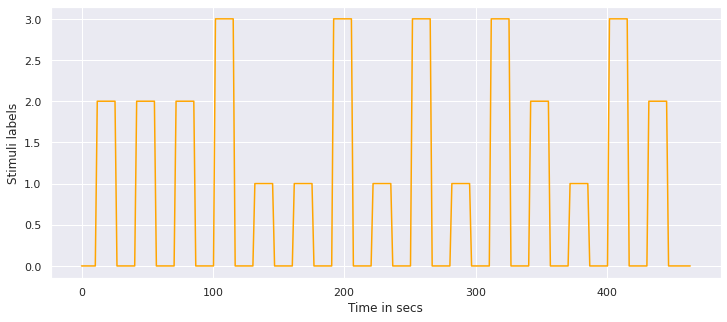

In [19]:
# Create a sequence of timepoints that a TR occurred on
time_points = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)

# Plot the data
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(time_points, stim_label_TR[0:vdc_TRs_run, 0], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('Time in secs')

#### C) Lag Hemodinamoco: ajuste temporal das labels

Text(0.5, 0, 'Time in secs')

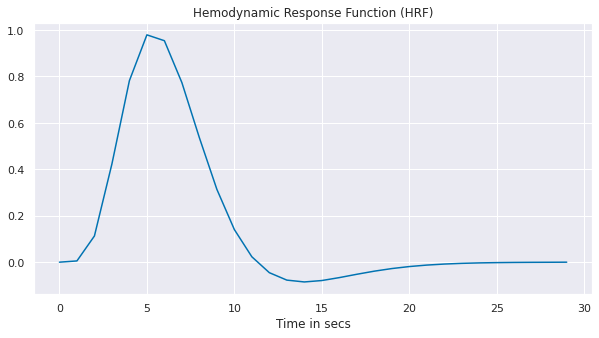

In [20]:
# Create an example HRF
hrf = hrf_func(temporal_resolution=1)

# Plot the canonical double gamma HRF
f, ax = plt.subplots(1,1, figsize = (10, 5))
ax.plot(range(30), hrf)

ax.set_title("Hemodynamic Response Function (HRF)")
ax.set_xlabel('Time in secs')

Text(0.5, 0.98, 'Stimulus Timing: Block 10 s (5 TRs)')

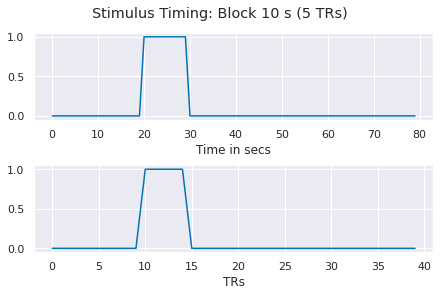

In [21]:
# Specify some parameters
trDuration = 2  # seconds
numTRs = 40 # How many TRs will you generate?
total_time = int(numTRs * trDuration)
temporal_res = 0.5 # 1/trDuration

stim_A = sim.generate_stimfunction(onsets=[20], 
                                   event_durations=[10], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res 
                                   )

# Plot the design
fig, (ax0, ax1) = plt.subplots(nrows=2, constrained_layout=True)

ax0.plot(stim_A.repeat(trDuration))
ax0.set_xlabel('Time in secs')

ax1.plot(stim_A)
ax1.set_xlabel('TRs')

fig.suptitle('Stimulus Timing: Block 10 s (5 TRs)')

Text(0.5, 0, 'TRs')

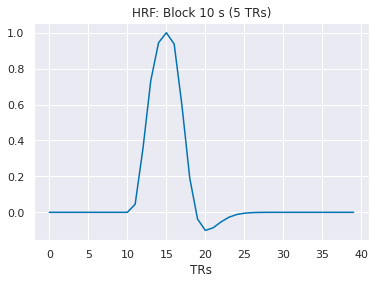

In [22]:
# Create the expected neural response
signal_func_A = sim.convolve_hrf(stimfunction=stim_A,
                                 tr_duration=trDuration,
                                 temporal_resolution=temporal_res,
                                 scale_function=1,
                                 )

plt.plot(signal_func_A)
plt.title('HRF: Block 10 s (5 TRs)')
plt.xlabel('TRs')

Text(0.5, 0, 'TRs')

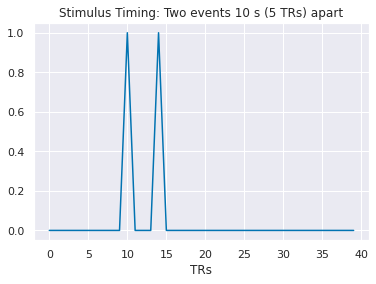

In [23]:
stim_B = sim.generate_stimfunction(onsets=[20,28],
                                   event_durations=[2,2], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res,
                                  )

#Plot the design
plt.plot(stim_B)
plt.title('Stimulus Timing: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')

Text(0.5, 0, 'TRs')

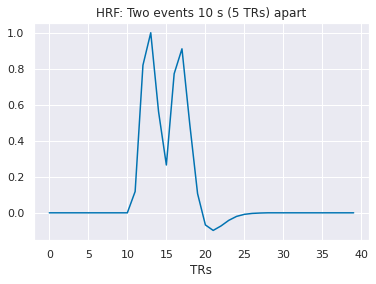

In [24]:
# Create the expected neural response
signal_func_B = sim.convolve_hrf(stimfunction=stim_B,
                                   tr_duration=2,
                                   temporal_resolution=temporal_res,
                                   scale_function=1,
                                   )

plt.plot(signal_func_B)
plt.title('HRF: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')

Text(0.5, 0, 'Time in secs')

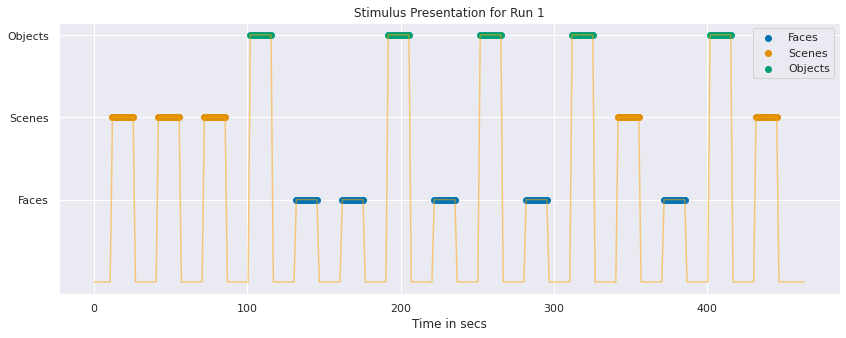

In [25]:
n_conditions = len(vdc_label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)
time_vals = stim_label_allruns[2, 0:150]
labels = stim_label_allruns[0, 0:150]

f, ax = plt.subplots(1,1, figsize = (14, 5))
    
# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_vals[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(vdc_label_dict.values())
    
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time in secs')

In [26]:
# Shift the data a certain amount
print('Amount of time shift: %0.1f' % vdc_hrf_lag) # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(vdc_hrf_lag / vdc_TR)  # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Apply the function
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

Amount of time shift: 4.5


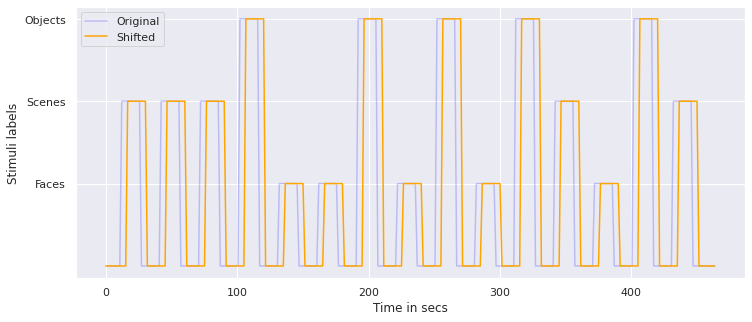

In [27]:
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='blue',alpha=0.2)
ax.plot(tr_time, stim_label_TR_shifted[0:310], c='orange')

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('Time in secs')

plt.legend(['Original', 'Shifted'])

#### D) Carregando dados fMRI 

In [28]:
print('available ROIs: ', vdc_all_ROIs)

available ROIs:  ['FFA', 'PPA']


In [29]:
roi_name = 'FFA'

# Apply the function to pull out the mask data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Check the dimensionality of the data
print('voxel by TR matrix - shape: ', epi_mask_data_all[vdc_all_ROIs.index(roi_name)].shape)
print('label list - shape: ', stim_label_TR_shifted.shape)

Loaded FFA mask
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
voxel by TR matrix - shape:  (5519, 930)
label list - shape:  (930,)


#### E) Ajustando o formato dos dados

In [30]:
# Extract bold data for non-zero labels
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index]
    return indexed_data, nonzero_labels

# Pull out the data from this ROI for these time points
roi_masked_data = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data, labels = reshape_data(stim_label_TR_shifted, roi_masked_data)

# What is the dimensionality of the data? We need the first dim to be the same
print('The %s has the dimensionality of: %d time points by %d voxels' % (roi_name, bold_data.shape[0], bold_data.shape[1]))

The FFA has the dimensionality of: 450 time points by 5519 voxels


#### D) Criação manual do Left-Out-Run-Out (LORO)

450


Text(0.5, 0, 'index')

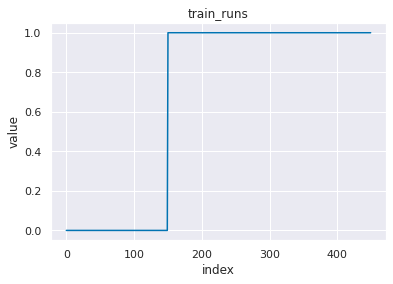

In [31]:
# Get run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1
print(len(stim_label_allruns[5,:]))

# Select a run
holdout_run_ids = 0

# Make an index list with one run left out.
train_runs = run_ids != holdout_run_ids

# Let's look at what the runs that will be used for training (value=1) and runs that will be used for testing (value=0).
plt.plot(train_runs)
plt.title('train_runs')
plt.ylabel('value')
plt.xlabel('index')

#### E) Normalização

In [32]:
print(bold_data.shape)
print(run_ids.shape)

(450, 5519)
(450,)


In [33]:
def normalize_new(bold_data_, run_ids):
    """normalized the data within each run
    
    Parameters
    --------------
    bold_data_: np.array, n_stimuli x n_voxels
    run_ids: np.array or a list
    
    Return
    --------------
    normalized_data
    """
    scaler = StandardScaler()
    data = []
    print(bold_data_.shape)
    print(run_ids.shape)
    for r in range(vdc_n_runs):
        data.append(scaler.fit_transform(bold_data_[run_ids == r, :]))
    normalized_data = np.vstack(data)
    return normalized_data

bold_data_normalized = normalize_new(bold_data, run_ids)

(450, 5519)
(450,)


#### F) Classificadores

In [34]:
# Split the training set and test set ... 
X_train = bold_data_normalized[train_runs,]
y_train = labels[train_runs]
X_test = bold_data_normalized[np.logical_not(train_runs),]
y_test = labels[np.logical_not(train_runs)]


# Create a classifier model for the training set 
model = LinearSVC(C=1)

# Fit the model
model.fit(X_train, y_train)

# Compute your evaluation on the test set
score = model.score(X_test, y_test)
print('Accuracy = %s' % score)

Accuracy = 0.88


In [35]:
def decode(data, labels, run_labels):
    scores = []
    models = []
    ps = PredefinedSplit(run_labels)

    # classifier
    model = LinearSVC()
    for train_index, test_index in ps.split():
        X_train, X_test = data[train_index], data[test_index]
        Y_train, Y_test = labels[train_index], labels[test_index]

        # fit an svm
        model.fit(X_train, Y_train)

        # calculate the accuracy for the hold-out run
        score = model.score(X_test, Y_test)
        models.append(model)
        scores.append(score)

    return((models, scores))

models, scores = decode(bold_data_normalized, labels, run_ids)
print('Decoding accuracy across the 3 folds: ', scores)

np.mean(scores)

Decoding accuracy across the 3 folds:  [0.88, 0.8933333333333333, 0.8466666666666667]


0.8733333333333334

#### G) Preparação dos dados para decode FFA e PPA

In [36]:

# choose a subject
sub = 'sub-01';

# Convert the shift from secs to TRs
shift_size = int(vdc_hrf_lag / vdc_TR) 

# Load subject labels
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir,sub) 

# Load the fMRI data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Convert the timing into TR indexes
TRs_run = int(epi_mask_data_all[0].shape[1] / vdc_n_runs)
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)
# Select and reshape FFA data 
bold_data_FFA, labels = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('FFA')])

# Select and reshape PPA data 
bold_data_PPA, _ = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('PPA')])

# Specify the classifiers that will be used
svc = LinearSVC()

# load run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1

Loaded labels for sub-01
Loaded FFA mask
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii


#### H) Decode FFA

In [37]:
models_ffa, scores_ffa = decode(bold_data_FFA, labels, run_ids)
mean_acc_ffa = np.mean(scores_ffa)
mean_acc_ffa

0.6511111111111111

#### I) Decode PPA

In [38]:
models_ppa, scores_ppa = decode(bold_data_PPA, labels, run_ids)
mean_acc_ppa = np.mean(scores_ppa)
mean_acc_ppa

0.47555555555555556

##### O modelo se comporta melhor na tarefa de decode de objetos comparado com faces em PPA e em FFA, dessa forma, sugerindo que PPA tem uma representação mais coerente dos objetos que das faces, dessa forma propiciando um melhor dicernimento. Esse exemplo tambem sugere que certas regiões do cerebro são realmente mais sensiveis a representações mais modulares de caregorias de objetos.

### III) Redução de dimensionalidade

##### A) Carregando dados

In [39]:
sub_id = 1
mask_name = 'FFA'

# Specify the subject name
sub = 'sub-%.2d' % (sub_id)
# Convert the shift into TRs
shift_size = int(vdc_hrf_lag / vdc_TR)  

# Load subject labels
stim_label_allruns = load_labels(vdc_data_dir, sub)

# Load run_ids
run_ids_raw = stim_label_allruns[5,:] - 1 

# Load the fMRI data using a mask
epi_mask_data_all = load_data(vdc_data_dir, sub, mask_name=mask_name)[0]

# This can differ per participant
print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
TRs_run = int(epi_mask_data_all.shape[1] / vdc_n_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data_raw, labels_raw = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Normalize raw data within each run
bold_normalized_raw = normalize(bold_data_raw, run_ids_raw)

# Down sample the data to be blockwise rather than trialwise. 
#We'll use the blockwise data for all the 
bold_data, labels, run_ids = blockwise_sampling(bold_data_raw, labels_raw, run_ids_raw)

# Normalize blockwise data within each run
bold_normalized = normalize(bold_data, run_ids)

Loaded  sub-01
Processing Start ...
Loaded FFA mask
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /home/osboxes/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  5519
Expected blocks: 45; Resampled blocks: 45


##### B) Covariancia

In [40]:
X = bold_normalized[10, :]
Y = bold_normalized[20, :]
cov_auto = np.cov(X, Y)[1][0]

print('Covariance: {}'.format(cov_auto))

Covariance: -0.03511234506686155


##### C) Correlação

In [41]:
corr_auto = np.corrcoef(X, Y)[0][1]

print('Correlation: {}'.format(corr_auto))

Correlation: -0.04726873436910835


##### D) PCA calculo e plot

In [42]:
# We now use the PCA function in scikit-learn to reduce the dimensionality of the data
# The number of components was chosen arbitrarily.
pca = PCA(n_components=20)
bold_pca = pca.fit_transform(bold_data)

print('Original data shape:', bold_data.shape)
print('PCA data shape:', bold_pca.shape)

Original data shape: (45, 5519)
PCA data shape: (45, 20)


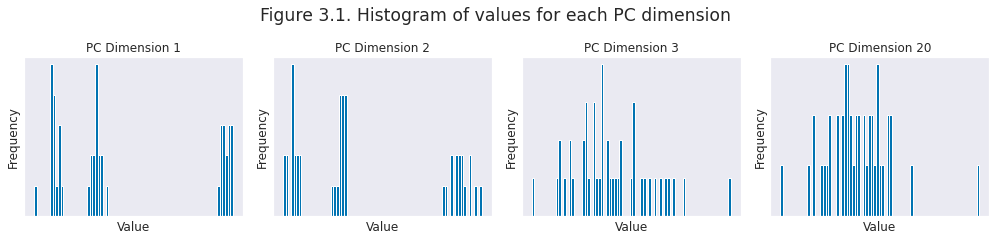

In [43]:
# Setting plotting parameter
n_bins=75

# Plot
n_plots = 4
components_to_plot = [0,1,2,19]
f, axes = plt.subplots(1, n_plots, figsize=(14, 14/n_plots))
st=f.suptitle("Figure 3.1. Histogram of values for each PC dimension ", fontsize="x-large")

for i in range(n_plots): 
    axes[i].hist(bold_pca[:, components_to_plot[i]], 
                 bins=n_bins)
    # mark the plots 
    axes[i].set_title('PC Dimension %d'%(components_to_plot[i]+1))
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Value')    
    axes[i].set_xticks([])
    axes[i].set_yticks([])    

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

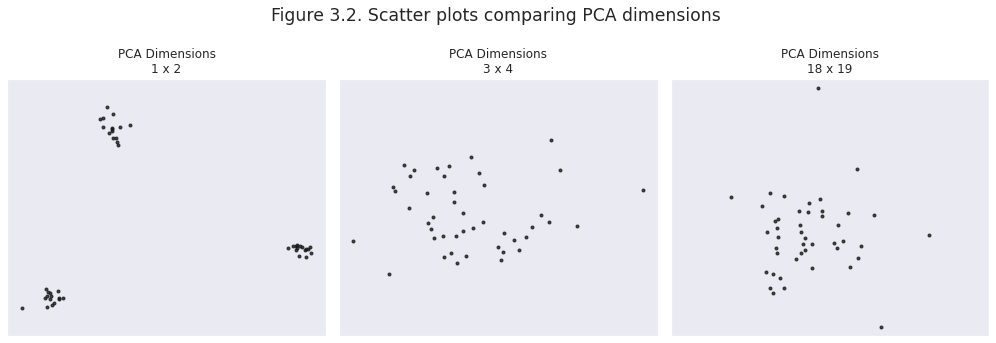

In [44]:

"""
Plot the low dim representation of the bold data
"""
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 3 
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca[:, 0], bold_pca[:, 1], 
                alpha=alpha_val, marker='.', color = 'k')
axes[1].scatter(bold_pca[:, 2], bold_pca[:, 3], 
                alpha=alpha_val, marker='.', color = 'k')
axes[2].scatter(bold_pca[:, 18], bold_pca[:, 19], 
                alpha=alpha_val, marker='.', color = 'k')

axes[0].set_title('PCA Dimensions\n1 x 2')
axes[1].set_title('PCA Dimensions\n3 x 4')
axes[2].set_title('PCA Dimensions\n18 x 19')

# modifications that are common to all plots 
for i in range(n_plots): 
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

##### E) Interpretando os componentes

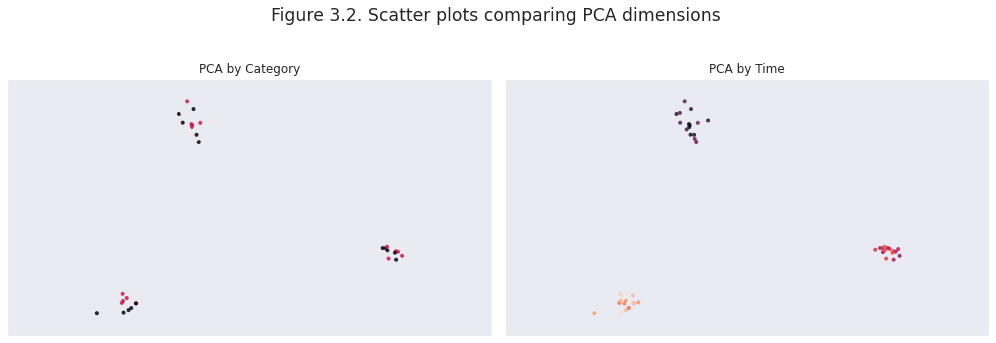

In [45]:
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 2
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca[:, 0], bold_pca[:, 1],
                alpha=alpha_val, marker='.', c = labels)
axes[1].scatter(bold_pca[:, 0], bold_pca[:, 1],
                alpha=alpha_val, marker='.', c = range(0, 45))

axes[0].set_title('PCA by Category')
axes[1].set_title('PCA by Time')

# modifications that are common to all plots
for i in range(n_plots):
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

##### F) Normalização

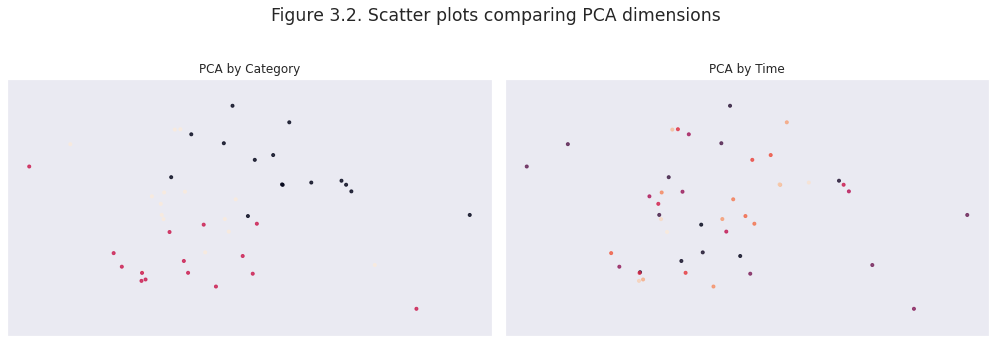

In [46]:
bold_pca_norm = pca.fit_transform(bold_normalized)

# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 2
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca_norm[:, 0], bold_pca_norm[:, 1],
                alpha=alpha_val, marker='.', c = labels)
axes[1].scatter(bold_pca_norm[:, 0], bold_pca_norm[:, 1],
                alpha=alpha_val, marker='.', c = range(0, 45))

axes[0].set_title('PCA by Category')
axes[1].set_title('PCA by Time')

# modifications that are common to all plots
for i in range(n_plots):
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

##### G) PCA, redução da dimencionalidade e classificação

In [47]:
from utils import decode

# Run a basic n-fold classification

# Get baseline, whole-brain decoding accuracy without PCA
print('Baseline classification')
print('Original size: ', bold_normalized.shape)
svc = SVC(kernel="linear", C=1)

start = time()
models, scores = decode(bold_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores)
print('Run time: %0.4fs' %(end - start))

Baseline classification
Original size:  (45, 5519)
Accuracy:  [0.8666666666666667, 1.0, 1.0]
Run time: 0.0411s


In [48]:
# Run the classifier on data in component space 
pca = PCA(n_components=20)
bold_pca_normalized = pca.fit_transform(bold_normalized)
print('PCA (c=%d) classification' % bold_pca_normalized.shape[1])
print('New size after PCA: ', bold_pca_normalized.shape)

start = time()
models_pca, scores_pca = decode(bold_pca_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores_pca)
print('Run time: %0.4fs' %(end - start))

PCA (c=20) classification
New size after PCA:  (45, 20)
Accuracy:  [0.8666666666666667, 1.0, 1.0]
Run time: 0.0025s


In [49]:
components_to_try = [5, 10, 15, 20, 25]
for components_n in components_to_try:
    pca_to_try = PCA(n_components=components_n)
    pca_to_use = pca_to_try.fit_transform(bold_normalized)
    models_pca_to_use, scores_pca_to_use = decode(pca_to_use, labels, run_ids, svc)
    print('Components: {} Accuracy: {}'.format(components_n, scores_pca_to_use))

Components: 5 Accuracy: [0.8666666666666667, 0.9333333333333333, 0.8]
Components: 10 Accuracy: [0.8666666666666667, 1.0, 1.0]
Components: 15 Accuracy: [0.8666666666666667, 1.0, 0.9333333333333333]
Components: 20 Accuracy: [0.9333333333333333, 1.0, 1.0]
Components: 25 Accuracy: [0.8666666666666667, 1.0, 1.0]


##### H) Pipeline - Seleção de variaveis com validação cruzada

In [50]:
# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=20)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

{'fit_time': array([0.06934834, 0.01795435, 0.01649547]), 'score_time': array([0.0011282 , 0.00102758, 0.00109005]), 'test_score': array([0.86666667, 0.93333333, 0.93333333]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.91


In [51]:
# Print train/test split
for cv_idx ,(train_index, test_index) in enumerate(ps.split(bold_normalized, labels)):
    print('CV iteration: %s' % cv_idx)
    print('Train_index: ')
    print(train_index)
    print('Test_index: ')
    print(test_index)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

CV iteration: 0
Train_index: 
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44]
Test_index: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
CV iteration: 1
Train_index: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44]
Test_index: 
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
CV iteration: 2
Train_index: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Test_index: 
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
{'fit_time': array([0.06934834, 0.01795435, 0.01649547]), 'score_time': array([0.0011282 , 0.00102758, 0.00109005]), 'test_score': array([0.86666667, 0.93333333, 0.93333333]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.91


##### I) Seleção de variavel - Univariada

In [52]:
# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', SelectKBest(f_classif, k=100)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

{'fit_time': array([0.01007485, 0.013273  , 0.01087546]), 'score_time': array([0.00517988, 0.00982094, 0.00076795]), 'test_score': array([1.        , 0.93333333, 1.        ]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.98
